In [7]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as sps
from scipy import special
import lmfit as lm
import pymc3 as pm
import theano.tensor as tt

In [127]:
def two_rates(t,k1,k2):
    if k1==k2:
        return k1**2*np.exp(-k1*t)
    else:
        return k1*k2/(k1-k2)*(np.exp(-k2*t)-np.exp(-k1*t))
    
def three_rates(t,k1,k2,k3):
    return k1*k2*k3/(k1-k2)*((np.exp(-k1*t)-np.exp(-k3*t))/(k1-k3)-(np.exp(-k2*t)-np.exp(-k3*t))/(k2-k3))

def four_rates(t,k1,k2,k3,k4):
    result=np.exp(-k2*t)/(k2-k3)/(k2-k4)
    result+=np.exp(-k3*t)*(k2-k1)/(k3-k1)/(k3-k2)/(k3-k4)
    result+=np.exp(-k1*t)/(k1-k3)/(k4-k1)
    result+=np.exp(-k4*t)*(k2-k1)/(k4-k1)/(k4-k2)/(k4-k3)
    return result*k1*k2*k3*k4/(k1-k2)

In [2]:
ddc_t0_three = np.load("ddc_t0_three.npy")
k1_t0_three = np.load("k1_t0_three.npy")
k3_t0_three = np.load("k3_t0_three.npy")
k5_t0_three = np.load("k5_t0_three.npy")

In [32]:
class TwoRates(pm.Continuous):
    """
    Two Rates reaction kinetics A -> X -> B
    Parameters
    ----------
    k1 : tensor
        k1 > 0, reaction rate A->X
    k2 : tensor
        k2 > 0, reaction rate X->B
    """

    def __init__(self, k1=None, k2=None,
                 *args, **kwargs):
        super(TwoRates, self).__init__(*args, **kwargs)
        self.k1 = k1
        self.k2 = k2
        self.mode = 1/k1+1/k2

    def logp(self, x):
        k1 = self.k1
        k2 = self.k2
        length = x.shape[0]
#        e2 = tt.exp(-k2*x)
#        e1 = tt.exp(-k1*x)
#        p = tt.switch(tt.eq(k1,k2),k1*k1*e1,k1*k1/(k1-k2)*(e2-e1))
        p = -k2*x*tt.log(1-tt.exp((k2-k1)*x)
        return tt.sum(tt.log(p))

In [42]:
with pm.Model() as model:
    k1 = pm.Uniform('k1', 0,5)
    k2 = pm.Uniform('k2', 0,5)
#    sample = TwoRates('sample',k1=k1,k2=k2,observed=k3_t0_three,testval=1)
    tab = pm.Exponential('tab',k1)
    tbc = pm.Exponential('tbc',k2)
    sample = tab + tbc
    measurement = pm.Normal('measurement',mu=sample,sd=0.1,observed=k3_t0_three)
        
#    start = pm.find_MAP()
    trace = pm.sample(10000)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -10,676: 100%|██████████| 200000/200000 [00:19<00:00, 10317.06it/s]
Finished [100%]: Average ELBO = -10,676
100%|██████████| 10000/10000 [04:24<00:00, 37.75it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x121407898>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x120a8a320>]], dtype=object)

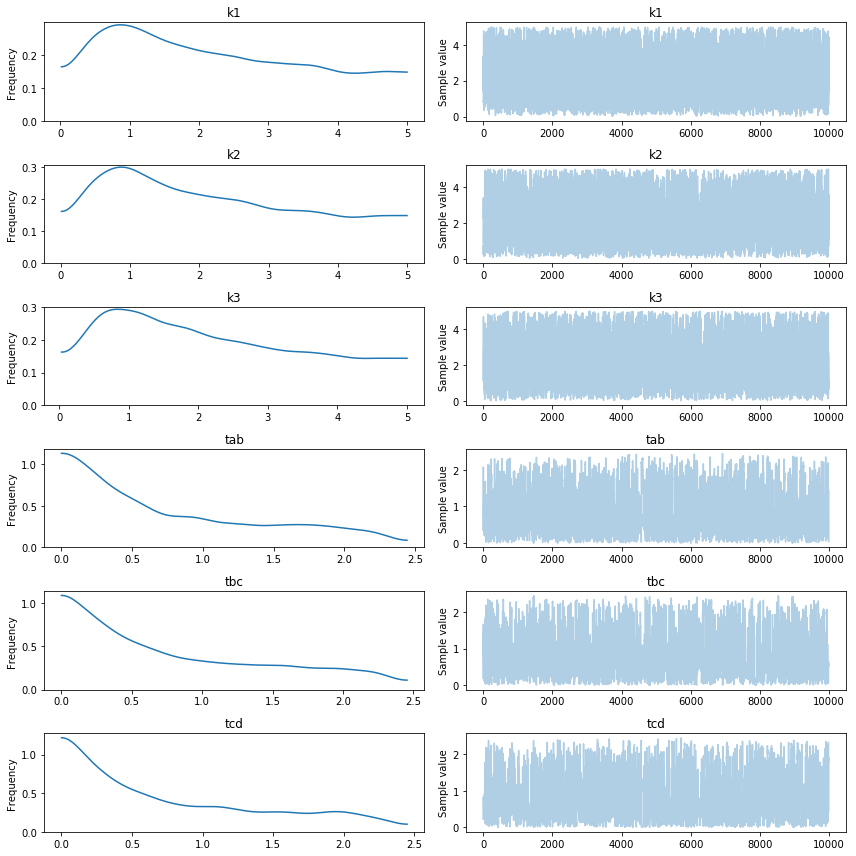

In [69]:
pm.traceplot(trace)

In [62]:
# we have now traces of k1 and k2 but k1 has to be greater than k2
# but k1 and k2 constantly change.  Why don't we call the greater of the
# two k1 and the smaller one k2
k1_trace=trace['k1']
k2_trace=trace['k2']

In [64]:
k1smaller = np.minimum(k1_trace,k2_trace)
k2bigger = np.maximum(k1_trace,k2_trace)
print(k1smaller.mean())
print(k2bigger.mean())

0.894424424899
2.82532995528


In [121]:
k3_hist,k3_edges = np.histogram(k3_t0_three,bins=20,density=True)
k3_sigma = np.sqrt(k3_hist)
k3_t0 = np.array([(first + next)/2 for first,next in zip(k3_edges[:-1],k3_edges[1:])])

In [122]:
t0_k3 = np.linspace(k3_t0.max(),k3_t0.min(),200)

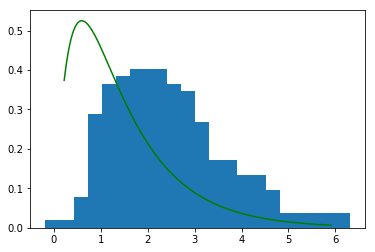

In [89]:
plt.bar(k3_t0,k3_hist)
plt.plot(t0_k3,two_rates(t0_k3,k1=k1smaller.mean(),k2=k2bigger.mean()),'g')

In [68]:
with pm.Model() as model:
    k1 = pm.Uniform('k1', 0,5)
    k2 = pm.Uniform('k2', 0,5)
    k3 = pm.Uniform('k3', 0,5)
#    sample = TwoRates('sample',k1=k1,k2=k2,observed=k3_t0_three,testval=1)
    tab = pm.Exponential('tab',k1)
    tbc = pm.Exponential('tbc',k2)
    tcd = pm.Exponential('tcd',k3)
    sample = tab + tbc + tcd
    measurement = pm.Normal('measurement',mu=sample,sd=0.1,observed=k3_t0_three)
        
#    start = pm.find_MAP()
    trace = pm.sample(10000)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -10,680: 100%|██████████| 200000/200000 [00:22<00:00, 8950.16it/s]
Finished [100%]: Average ELBO = -10,680
100%|██████████| 10000/10000 [3:09:37<00:00,  1.14s/it]    


In [104]:
# we have now traces of k1 and k2 but k1 has to be greater than k2
# but k1 and k2 constantly change.  Why don't we call the greater of the
# two k1 and the smaller one k2
k1_trace=trace['k1'][:2000]
k2_trace=trace['k2'][:2000]
k3_trace=trace['k3'][:2000]

In [105]:
k = np.vstack((k1_trace,k2_trace,k3_trace))
k.shape

(3, 2000)

In [106]:
k.sort(axis=0)

In [107]:
for kk in k:
    print(kk.mean())

0.975811700828
2.17025098868
3.52405079417


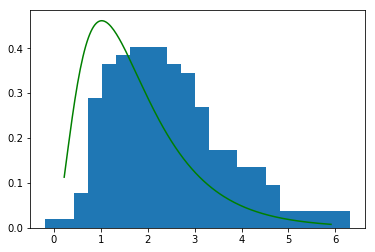

In [108]:
i=2000
plt.bar(k3_t0,k3_hist)
plt.plot(t0_k3,three_rates(t0_k3,k1=k[0].mean(),k2=k[1].mean(),k3=k[2].mean()),'g')

In [129]:
with pm.Model() as model:
    k1 = pm.Uniform('k1', 0,10)
    k2 = pm.Uniform('k2', 0,10)
    k3 = pm.Uniform('k3', 0,10)
    k4 = pm.Uniform('k4', 0,10)
#    sample = TwoRates('sample',k1=k1,k2=k2,observed=k3_t0_three,testval=1)
    tab = pm.Exponential('tab',k1)
    tbc = pm.Exponential('tbc',k2)
    tcd = pm.Exponential('tcd',k3)
    tde = pm.Exponential('tde',k4)
    sample = tab + tbc + tcd + tde
    measurement = pm.Normal('measurement',mu=sample,sd=0.1,observed=k3_t0_three)
        
#    start = pm.find_MAP()
    trace = pm.sample(10000)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -10,685: 100%|██████████| 200000/200000 [00:26<00:00, 7523.41it/s]
Finished [100%]: Average ELBO = -10,685
100%|██████████| 10000/10000 [29:21<00:00,  5.68it/s] 


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1293b78d0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x12a26def0>]], dtype=object)

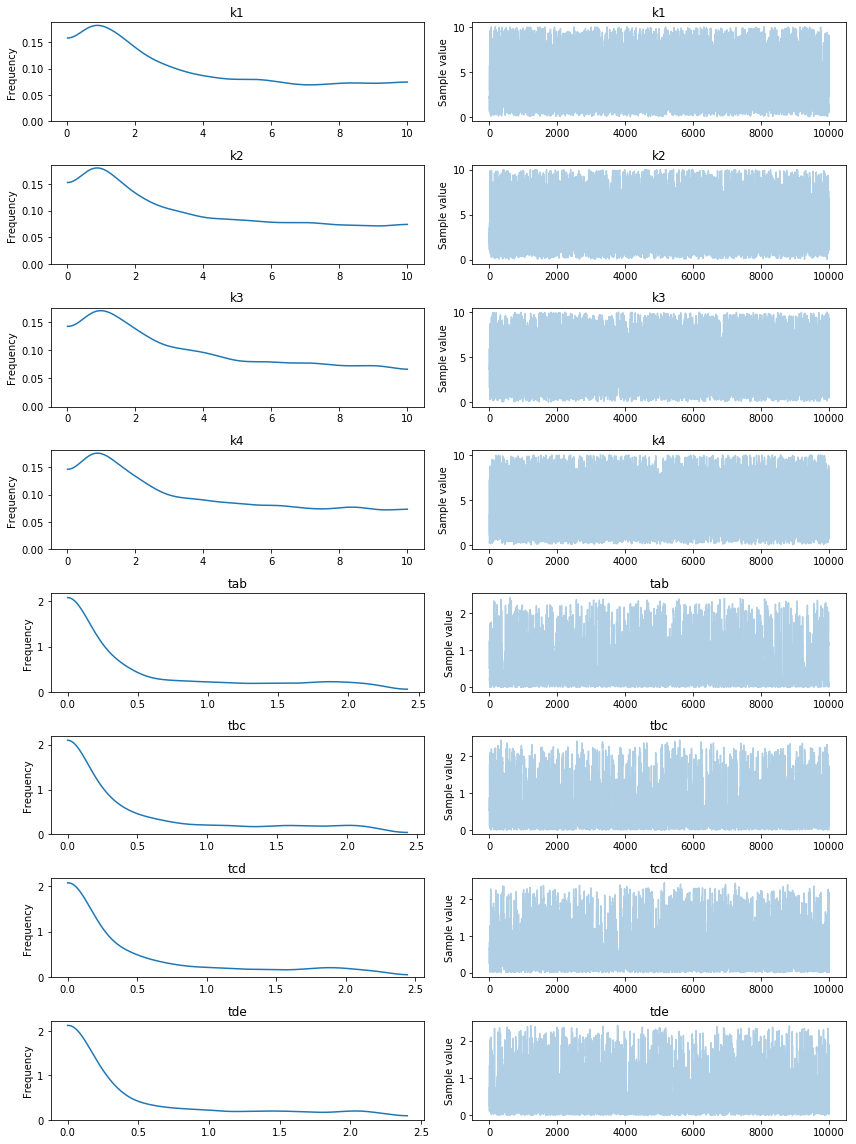

In [130]:
pm.traceplot(trace)

In [131]:
# we have now traces of k1 and k2 but k1 has to be greater than k2
# but k1 and k2 constantly change.  Why don't we call the greater of the
# two k1 and the smaller one k2
k1_trace=trace['k1'][:2000]
k2_trace=trace['k2'][:2000]
k3_trace=trace['k3'][:2000]
k4_trace=trace['k4'][:2000]

In [132]:
k = np.vstack((k1_trace,k2_trace,k3_trace,k4_trace))
k.sort(axis=0)

In [133]:
for kk in k:
    print(kk.mean(),kk.std())

0.984043523667 0.653419122612
2.92369886658 1.71345758505
5.22994249572 2.0650530334
7.50172866965 1.89433036119


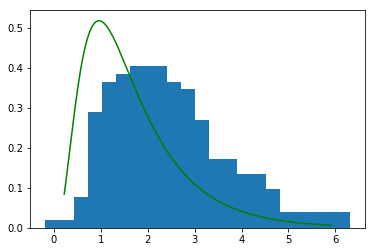

In [134]:
plt.bar(k3_t0,k3_hist)
plt.plot(t0_k3,four_rates(t0_k3,k1=k[0].mean(),k2=k[1].mean(),k3=k[2].mean(),k4=k[3].mean()),'g')